## **ADC Charge Caliberation**

In [89]:
%matplotlib inline
from ctypes import *
import numpy as np
from matplotlib import pyplot as plt
import drs4lib as drs
import time

#### **Read Data**

In [90]:
fname='data/chargeCalib_run2/events.dat'

In [93]:
status,wd=drs.get_adc_events(fname,0,50)
if status!=0:
    print("ERROR !! ecode = ",status)
print(wd.nbytes/1024**2 ," MB occupied")

3.1875  MB occupied


         Plot All Events

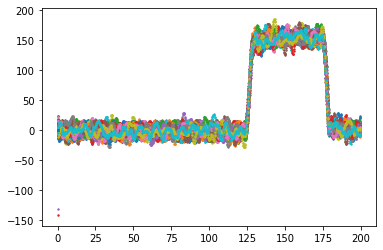

In [94]:
end=-1
start=0
chID=2
for eventID in range(len(wd)):
    dta=np.transpose(wd[eventID][chID])
    plt.scatter(dta[0][start:end],dta[1][start:end],s=2)


#### **ADC integration**

In [95]:
def ADC_integral(wf,tm,ch,trig,n_off,i_window,freq,f_edge):
    i=1
    t_sign=1
    if f_edge==False :
        t_sign=-1
    integ=0
    while(i<1024):
        if wf[ch][i]*t_sign < trig*t_sign:
            break
        i+=1
    start=i
    if(start>1023): 
        return 0,start,i
    if n_off>0:
        while(i>0):
            if tm[ch][start]-tm[ch][i] > n_off:
                start=i
                break
            i-=1
    else:
        while(i<1024):
            if tm[ch][start]-tm[ch][i] < n_off:
                start=i
                break
            i+=1
    window=0
    while i<1024 and window<i_window:
        dt=tm[ch][i]-tm[ch][i-1]
        window+=dt
        integ+=dt*wf[ch][i]
        i+=1
    return integ,start,i       

        ADC integration function here

In [96]:
channel=2
trigger_level=40
neg_offset=-8
integrate_window=50 +2 *neg_offset
frequency=5.12
falling_edge=False

waveform=np.zeros((8,1024))
tme=np.zeros((8,1024))

        Visualization

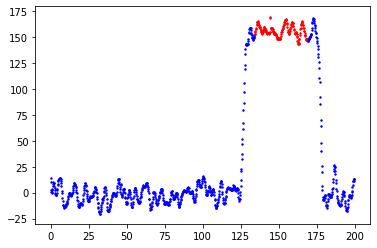

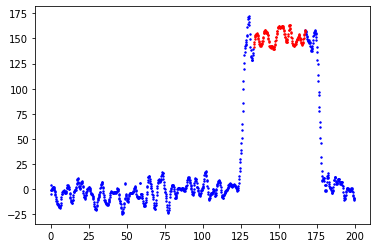

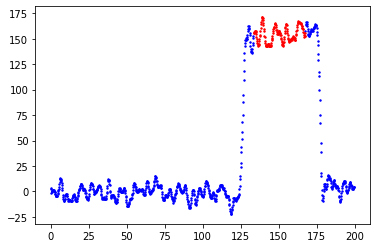

In [97]:
integral=[]
for eventID in range(3):
    plt.figure()
    dta=np.transpose(wd[eventID][channel])
    waveform[channel]=dta[1]
    tme[channel]=dta[0]
    inte,s,e=ADC_integral(waveform,tme,channel,trigger_level,neg_offset,integrate_window,frequency,falling_edge)
    integral.append(inte)
    plt.scatter(dta[0][0:s],dta[1][0:s],s=2,c='b')
    plt.scatter(dta[0][e:],dta[1][e:],s=2,c='b')
    plt.scatter(dta[0][s:e],dta[1][s:e],s=2,c='r')
# plt.xlim((-100,0))

       Integration of For Charge Claiberation

In [98]:
READ_EVENTS_LENGTH=150

channel=2
trigger_level=40
neg_offset=-8
integrate_window=50 +2 *neg_offset
frequency=5.12
falling_edge=False

waveform=np.zeros((8,1024))
tme=np.zeros((8,1024))

In [99]:
fnames=['data/chargeCalib_run2','data/chargeCalib_run3','data/chargeCalib_run4',
       'data/chargeCalib_run5','data/chargeCalib_run6','data/chargeCalib_run7',
       'data/chargeCalib_run8','data/chargeCalib_run9']

volts=[160,200,240,280,300,320,360,400]
print(len(fnames),len(volts))

8 8


In [50]:
calib_integral=dict()
for i in range(len(fnames)):
    status=0
    start_id=0
    integral=[]
    print("Doing for File in : ",fnames[i])
    while(status==0):
        status,wd=drs.get_adc_events(fnames[i]+'/events.dat',start_id,start_id+READ_EVENTS_LENGTH-1)
        n=len(wd)
        if status!=0:
            print("ERROR !! ecode = ",status)
            if status>0:
                n=status-start_id
            else:
                n=0
        else:
            print("\t",wd.nbytes/1024**2 ," MB occupied for EId : ",start_id," to ",start_id+n)
        for eventID in range(n-1):
            dta=np.transpose(wd[eventID][channel])
            waveform[channel]=dta[1]
            tme[channel]=dta[0]
            inte,s,e=ADC_integral(waveform,tme,channel,trigger_level,neg_offset,integrate_window,frequency,falling_edge)
            integral.append(inte)
            if(inte<1):
                print(inte,"eventID : ",eventID+start_id)
#         del wd
        start_id+=READ_EVENTS_LENGTH
        
    calib_integral.update({i:np.array(integral)})

Doing for File in :  data/chargeCalib_run2
	 9.375  MB occupied for EId :  0  to  150
	 9.375  MB occupied for EId :  150  to  300
	 9.375  MB occupied for EId :  300  to  450
	 9.375  MB occupied for EId :  450  to  600
	 9.375  MB occupied for EId :  600  to  750
	 9.375  MB occupied for EId :  750  to  900
	 9.375  MB occupied for EId :  900  to  1050
	 9.375  MB occupied for EId :  1050  to  1200
	 9.375  MB occupied for EId :  1200  to  1350
	 9.375  MB occupied for EId :  1350  to  1500
	 9.375  MB occupied for EId :  1500  to  1650
	 9.375  MB occupied for EId :  1650  to  1800
	 9.375  MB occupied for EId :  1800  to  1950
ERROR !! ecode =  2000
Doing for File in :  data/chargeCalib_run3
	 9.375  MB occupied for EId :  0  to  150
	 9.375  MB occupied for EId :  150  to  300
	 9.375  MB occupied for EId :  300  to  450
	 9.375  MB occupied for EId :  450  to  600
	 9.375  MB occupied for EId :  600  to  750
	 9.375  MB occupied for EId :  750  to  900
	 9.375  MB occupied for EI

In [16]:
sum(x[0])

1986.0

5028.78359514649 5474.654038255177 58.0 74.3117405181144
8589.334725596374 9734.769652745395 54.0 190.9058211915032


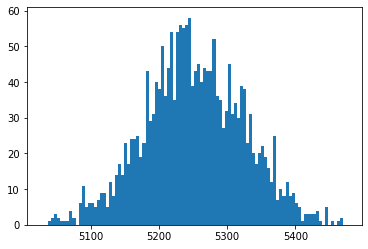

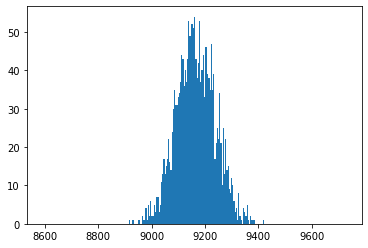

In [57]:
j=0
mn=np.average(calib_integral[j])
st=np.std(calib_integral[j])
x=plt.hist(calib_integral[j],bins=100,range=(mn-3*st,mn+3*st))
sta=st
print(mn-3*st,mn+3*st,max(x[0]),st)
plt.figure()
j=3
mn=np.average(calib_integral[j])
st=np.std(calib_integral[j])
x=plt.hist(calib_integral[j], bins=np.arange(mn-3*st,mn+3*st,6*sta/100))
print(mn-3*st,mn+3*st,max(x[0]),st)

id =  0  ,  fname :  data/chargeCalib_run2
id =  1  ,  fname :  data/chargeCalib_run3
id =  2  ,  fname :  data/chargeCalib_run4
id =  3  ,  fname :  data/chargeCalib_run5
id =  4  ,  fname :  data/chargeCalib_run6
id =  5  ,  fname :  data/chargeCalib_run7
id =  6  ,  fname :  data/chargeCalib_run8
id =  7  ,  fname :  data/chargeCalib_run9


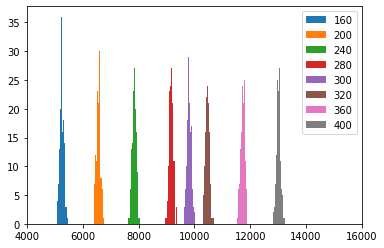

In [100]:
sta=np.std(calib_integral[0])
mean_integrals=[]
mean_integrals_std=[]
for i in calib_integral:
    mn=np.average(calib_integral[i])
    st=np.std(calib_integral[i])
    mean_integrals.append(mn)
    mean_integrals_std.append(st)
    x=plt.hist(calib_integral[i],bins=np.arange(mn-3*st,mn+3*st,6*sta/200),
               label=str(volts[i]))
plt.legend()
plt.xlim([4000,16000])
mean_integrals=np.array(mean_integrals)
mean_integrals_std=np.array(mean_integrals_std)

<ErrorbarContainer object of 3 artists>

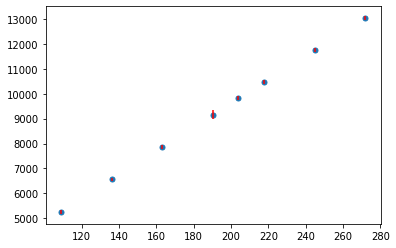

In [88]:
Q_expected=integrate_window*volts/50.0
plt.errorbar(Q,mean_integrals,mean_integrals_std,ecolor='r',markersize=5,fmt='o',barsabove=True)

In [113]:
from scipy.optimize import curve_fit 
def linear_function(x,a,b):
    return a+b*x

In [117]:
params,cov=curve_fit(linear_function,Q,mean_integrals)
print("offset = ",params[0],"  +/- ",np.sqrt(cov[0][0]))
print("R = ",params[1],"  +/- ",np.sqrt(cov[1][1]))

offset =  73.30779544771889   +/-  17.056272870723568
R =  47.70079656055947   +/-  0.08580627380580923


<ErrorbarContainer object of 3 artists>

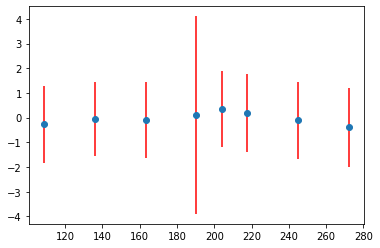

In [119]:
plt.errorbar(Q,(mean_integrals-75)/47.7-Q,mean_integrals_std/47.7,ecolor='r',fmt='o')